# Classification 2

## Exercise 2: Classification using KNN

### Overview

In this exercise, we will begin our classification journey by building a baseline model using KNN. KNN is a simple, easy to understand method that is also very easy to use. It is a nonparametric algorithm that does not make any deep underlying assumption of the data. As such, they are free to 'learn' from the data without restriction. However they do have disadvantages such as:

- More data: Require a lot more training data to estimate the mapping function.
- Slower: A lot slower to train as they often have far more parameters to train.
- Overfitting: More of a risk to overfit the training data and it is harder to explain why specific predictions are made.

[This](https://machinelearningmastery.com/parametric-and-nonparametric-machine-learning-algorithms/) blog article explains this further.

To do this exercise, you will need to have completed Exercise 1 and use the data saved from that. Complete the tasks in the text or in the code comments. You will also need to refer to the [Scikit documentation](https://scikit-learn.org/stable/documentation.html).

### Library Imports

In [1]:
# Basic Library Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
%matplotlib inline

# modelling 
from imblearn.over_sampling import RandomOverSampler, SMOTE

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_curve, auc

# silence warnings
warnings.filterwarnings('ignore')

## Data Ingestion

In [2]:
# Read in the CSV file saved from Exercise 1
file_path = '../data/interim/telco_churn.csv'
# The 1st column of the csv file should be the customer ID, which is loaded in the the Dataframe's index
input_data = pd.read_csv(file_path, index_col=0)

In [3]:
# Validate that data is as expected
input_data.head()

,Gender,SeniorCitizen,Partner,Dependents,TenureMonths,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,ChurnLabel
CustomerID,,,,,,,,,,,,,,,,,,,,
3668-QPYBK,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,M2M,Yes,mcheck,53.85,108.15,Yes
9237-HQITU,Female,No,No,Yes,2,Yes,No,FiberOptic,No,No,No,No,No,No,M2M,Yes,echeck,70.70,151.65,Yes
9305-CDSKC,Female,No,No,Yes,8,Yes,Yes,FiberOptic,No,No,Yes,No,Yes,Yes,M2M,Yes,echeck,99.65,820.50,Yes
7892-POOKP,Female,No,Yes,Yes,28,Yes,Yes,FiberOptic,No,No,Yes,Yes,Yes,Yes,M2M,Yes,echeck,104.80,3046.05,Yes
0280-XJGEX,Male,No,No,Yes,49,Yes,Yes,FiberOptic,No,Yes,Yes,No,Yes,Yes,M2M,Yes,transfer,103.70,5036.30,Yes


In [4]:
# Size of data - TASK: Validate that it's (7032, 20)
input_data.shape

(7032, 20)

## Feature Engineering

In [5]:
# Outcome variable
# Instead of keeping the values, we will encode as 1s and 0s using the map function
output_var_name = 'ChurnLabel'
output_var = input_data[output_var_name]
output_var = output_var.map({'Yes': 1, 'No': 0})
# Note that the map function can be run only once. You will get an error if you try to run this cell again as Yes/No are no longer valid values in this feature. 

# Count the number of rows for each outcome value
print("Row count for each outcome")
print(output_var.value_counts(normalize=True))

# Remove the outcome variable from the main dataframe
input_data.drop(output_var_name, axis=1, inplace=True)

Row count for each outcome
0    0.734215
1    0.265785
Name: ChurnLabel, dtype: float64


In [6]:
# Next, we want to define 3 lists for each of the data types found in our data i.e. Numerical, Categorical (more than 2 values), Binary (2 values only)

# Numerical features
num_features = [key for key in dict(input_data.dtypes) if dict(input_data.dtypes)[key] in ['int64', 'float64']]
print(num_features) # TASK: Confirm the columns based on Exercise 1

['TenureMonths', 'MonthlyCharges', 'TotalCharges']


In [7]:
# Define the 4 categorical features as a list of strings. These are the non-numerical features that do not have Yes/No values
cat_features = ['Gender', 'InternetService', 'Contract', 'PaymentMethod']

In [8]:
# 1. Get the list of non-numerical features (both categorical and binary).
bin_features = [col for col in input_data.columns if col not in cat_features + num_features]
print(f"List of binary features: {bin_features}") # TASK: Confirm the resulting list

List of binary features: ['SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling']


In [9]:
# Encoding the binary features. Similar to the outcome variable, we will need to convert the values of these features from Yes/No to 1/0.
# Note: As an alternative, this could have been done when building the pipeline.
for col in bin_features:
    input_data[col] = input_data[col].map({'Yes':1, 'No':0})

In [10]:
# Display values after encoding
input_data.head()

,Gender,SeniorCitizen,Partner,Dependents,TenureMonths,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
CustomerID,,,,,,,,,,,,,,,,,,,
3668-QPYBK,Male,0,0,0,2,1,0,DSL,1,1,0,0,0,0,M2M,1,mcheck,53.85,108.15
9237-HQITU,Female,0,0,1,2,1,0,FiberOptic,0,0,0,0,0,0,M2M,1,echeck,70.70,151.65
9305-CDSKC,Female,0,0,1,8,1,1,FiberOptic,0,0,1,0,1,1,M2M,1,echeck,99.65,820.50
7892-POOKP,Female,0,1,1,28,1,1,FiberOptic,0,0,1,1,1,1,M2M,1,echeck,104.80,3046.05
0280-XJGEX,Male,0,0,1,49,1,1,FiberOptic,0,1,1,0,1,1,M2M,1,transfer,103.70,5036.30


## Model Building

In [11]:
# Define preprocessing pipeline. Reminder that the binary features have already been encoded and thus only passed through
# Remember to add the library imports for ColumnTransformer, StandardScaler, OneHotEncoder to the imports above
preprocess = ColumnTransformer(
    transformers=[
        ('standardscaler', StandardScaler(), num_features),
        ('onehotencoder', OneHotEncoder(), cat_features)
    ],
    remainder='passthrough'
)

In [12]:
preprocessed_data = preprocess.fit_transform(input_data)

In [13]:
# Train/Test Split
# TASK: Split the data into 70:30 train/test. Use the random_state=42
x_train, x_test, y_train, y_test = train_test_split(preprocessed_data, output_var, test_size=0.3, random_state=42)

In [14]:
# Check the dimensions of the data. TASK: Confirm as (2110, 19)
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {}".format(sum(y_train==0)))

Before OverSampling, counts of label '1': 1281
Before OverSampling, counts of label '0': 3641


In [15]:
# Create instance of RandomOverSampler to tackle imbalance dataset
over_sample = RandomOverSampler(random_state=0)
x_train_res, y_train_res = over_sample.fit_resample(x_train, y_train.ravel())
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

After OverSampling, counts of label '1': 3641
After OverSampling, counts of label '0': 3641


In [16]:
# Train the model
model = KNeighborsClassifier(n_neighbors=5)
model.fit(x_train_res, y_train_res);

### Evaluation

For regression problems, we are familiar with common metrics such as Root Means Square Error (RMSE) and the Coefficient of Determination (R<sup>2</sup> value).

With classification problems, we need a different set of metrics to evaluate the model. Here, we use metrics such as:

- Confusion Matrix
- Precision
- Recall
- F1 score
- ROC and AUC

Read the following blog posts to get familiar with these terms:

- https://hackernoon.com/idiots-guide-to-precision-recall-and-confusion-matrix-b32d36463556
- https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9

Once you are done, proceed to the next cells.


In [17]:
# Apply the model on the test data
pred_test = model.predict(x_test)

In [18]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, pred_test)
print(cm)

[[1026  496]
 [ 137  451]]


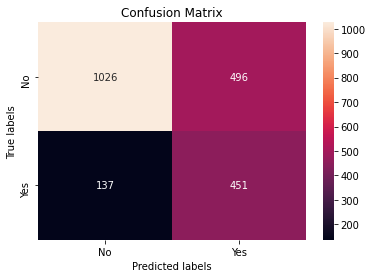

In [19]:
# Confusion Matrices typically are displayed in a graphical manner. Run this cell to display the matrix using this code snippet found online.
labels = ['No','Yes']
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt="d"); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels)
plt.show()

In [20]:
# 1. Accuracy = Sum of correctly predicted outcomes divided by total number of samples
accuracy = accuracy_score(y_test, pred_test)
print("Accuracy: {:.5f}".format(accuracy))

Accuracy: 0.70000


In [21]:
# 2. Precision - Of those predicted positive, how many of them are actual positive.
precision = precision_score(y_test, pred_test)
print("Precision: {:.5f}".format(precision))

Precision: 0.47624


In [22]:
# 3. Recall - how many of the actual positives our model is predicting as positives
recall = recall_score(y_test, pred_test)
print("Recall: {:.5f}".format(recall))

Recall: 0.76701


In [23]:
# 4. F1 score
f1 = f1_score(y_test, pred_test)
print("F1 Score: {:.5f}".format(f1))

F1 Score: 0.58762


In [24]:
# Alternatively, we can calculate all these metrics in one call using the classification_report function
print(classification_report(y_test, pred_test, digits=5))

              precision    recall  f1-score   support

           0    0.88220   0.67411   0.76425      1522
           1    0.47624   0.76701   0.58762       588

    accuracy                        0.70000      2110
   macro avg    0.67922   0.72056   0.67593      2110
weighted avg    0.76907   0.70000   0.71503      2110



At this point, take a step back and try to understand these numbers. 

- What do these metrics mean in the context of the problem? 
- Which error (Type 1 or Type 2) is more important for this problem? And thus which metric is more important, Precision or Recall?

In [25]:
# TASK: Compute ROC and AUC. Note that roc_curve() returns 3 values. You will only need the first 2 as input to auc() i.e. use _ as the 3rd output
fpr, tpr, _ = roc_curve(y_test, pred_test)
roc_auc = auc(fpr, tpr)

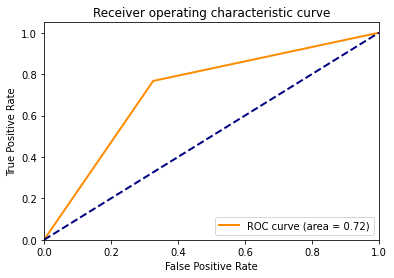

In [26]:
# Run this cell to plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.show()

### SMOTE

 Beside `RandomOverSampler`, you can also try to use another popular method `Synthetic Minority Oversampling Technique` (SMOTE)

In [27]:
over_sample = SMOTE(random_state=2)
x_train_res, y_train_res = over_sample.fit_resample(x_train, y_train.ravel())
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

After OverSampling, counts of label '1': 3641
After OverSampling, counts of label '0': 3641


In [28]:
model.fit(x_train_res, y_train_res);

In [29]:
# Apply the model on the test data
pred_test = model.predict(x_test)

In [30]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, pred_test)
print(cm)

[[1056  466]
 [ 138  450]]


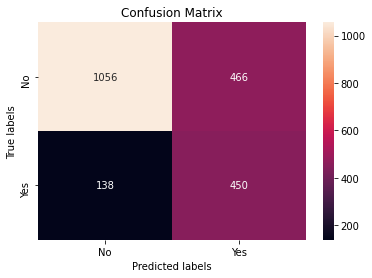

In [31]:
# Confusion Matrices typically are displayed in a graphical manner. Run this cell to display the matrix using this code snippet found online.
labels = ['No','Yes']
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt="d"); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels)
plt.show()

In [32]:
# 1. Accuracy = Sum of correctly predicted outcomes divided by total number of samples
accuracy = accuracy_score(y_test, pred_test)
print("Accuracy: {:.5f}".format(accuracy))

Accuracy: 0.71374


In [33]:
# 2. Precision - Of those predicted positive, how many of them are actual positive.
precision = precision_score(y_test, pred_test)
print("Precision: {:.5f}".format(precision))

Precision: 0.49127


In [34]:
# 3. Recall - how many of the actual positives our model is predicting as positives
recall = recall_score(y_test, pred_test)
print("Recall: {:.5f}".format(recall))

Recall: 0.76531


In [35]:
# 4. F1 score
f1 = f1_score(y_test, pred_test)
print("F1 Score: {:.5f}".format(f1))

F1 Score: 0.59840


In [36]:
# Alternatively, we can calculate all these metrics in one call using the classification_report function
print(classification_report(y_test, pred_test, digits=5))

              precision    recall  f1-score   support

           0    0.88442   0.69382   0.77761      1522
           1    0.49127   0.76531   0.59840       588

    accuracy                        0.71374      2110
   macro avg    0.68784   0.72957   0.68801      2110
weighted avg    0.77486   0.71374   0.72767      2110



In [37]:
# TASK: Compute ROC and AUC. Note that roc_curve() returns 3 values. You will only need the first 2 as input to auc() i.e. use _ as the 3rd output
fpr, tpr, _ = roc_curve(y_test, pred_test)
roc_auc = auc(fpr, tpr)

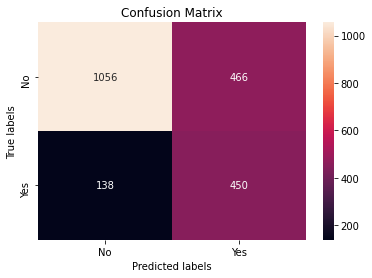

In [38]:
# Confusion Matrices typically are displayed in a graphical manner. Run this cell to display the matrix using this code snippet found online.
labels = ['No','Yes']
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt="d"); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels)
plt.show()

Congratulations! You have built a basic classication model. Complete the lesson quiz and proceed to the next lesson.